In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import ast
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tangles.movietangles.convenience import *
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [3]:
seps, sepidtokeyword = csv_to_setseperationsystem('../data/data_K3.csv')
with open('../orders/orders_O12_K3', 'rb') as f:
    order_O12 = pickle.load(f)
lvltokeyword = [sepidtokeyword[x] for x in np.argsort(order_O12)[:140]]
with open('../results/interesting_umbrella_tm_K3', 'rb') as f:
    interesting_umbrella_tm = pickle.load(f)
oriented_seps = seps[:,np.argsort(order_O12)[:140]]

How many movies are tagged with blood, blood and gore, and gore resp?

In [13]:
print((oriented_seps[:,12] == 1).sum())
print((oriented_seps[oriented_seps[:,14] == 1,12] == 1).sum())
print((oriented_seps[:,14] == 1).sum())

264
69
235


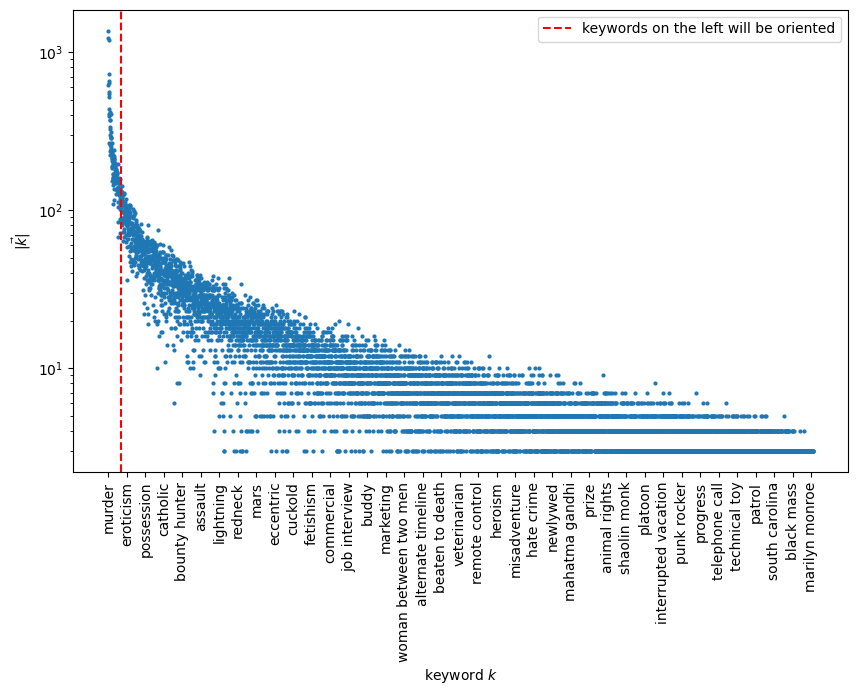

In [5]:
labels = [sepidtokeyword[id][0] for id in np.argsort(order_O12)]
sizes_O12 = [np.count_nonzero(seps[:,x] == 1) for x in np.argsort(order_O12)]
plt.figure(figsize = (10,6))
O12_str = np.argsort(order_O12).astype(str)
plt.scatter(O12_str, np.array(sizes_O12), s = 4)
plt.xticks(O12_str[::200], labels[::200], rotation=90)
plt.xlabel('keyword $k$')
plt.ylabel(r'$| \vec{k} |$')
plt.yscale('log')
plt.axvline(140, color = 'r', linestyle ='--', label = "keywords on the left will be oriented")
plt.legend()
#plt.savefig('/home/ocke/Documents/BA-Tangles/tex/images/O12_sizes.png', bbox_inches='tight')

Checks if any level is associated with more than one keyword:

In [ ]:
np.any([len(x) > 1 for x in lvltokeyword])

Calculates the first two principal componets of the matrix containing the interesting umbrella tangles:

In [36]:
pca = PCA(n_components= 2)
principal_components = pca.fit_transform(interesting_umbrella_tm)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

Finds the optimal number of clusters:

In [ ]:
silhouette_scores = []
k_values = range(2, 50)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state = 42)
    kmeans.fit(pca_df[['PC1', 'PC2']])
    score = silhouette_score(pca_df[['PC1', 'PC2']], kmeans.labels_)
    silhouette_scores.append(score)
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('number of cluster k')
plt.ylabel('Silhouette-Score')
plt.title('Silhouette-Analyse')
plt.grid()
plt.show()

print("For", k_values[np.argmax(silhouette_scores)], "clusters we get the best average silhouette score of", np.max(silhouette_scores))

Clusters the Tangles and plots them:

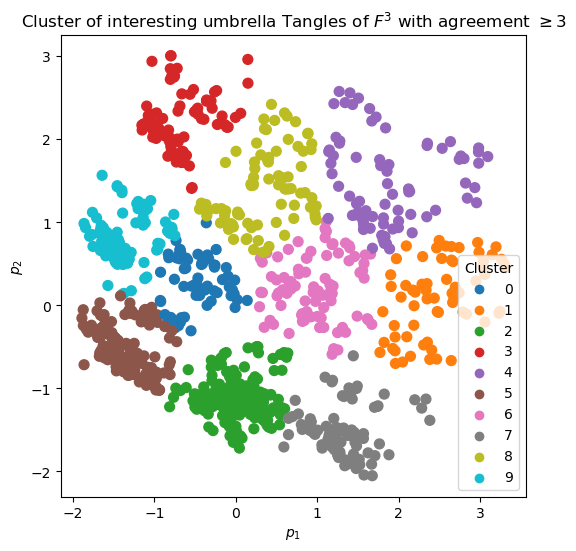

In [37]:
kmeans = KMeans(n_clusters=10, random_state=42)
pca_df['Cluster'] = kmeans.fit_predict(pca_df[['PC1', 'PC2']])

plt.figure(figsize=(6,6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap = cm.tab10, s=50)
plt.title(r'Cluster of interesting umbrella Tangles of $F^3$ with agreement $\geq 3$')
plt.xlabel('$p_1$')
plt.ylabel('$p_2$')

for i in range(10):
    plt.scatter([], [], c=[cm.tab10(plt.Normalize(0, 9)(i))], label=str(i))
plt.legend(title='Cluster', loc='best')
plt.savefig('/home/ocke/Documents/BA-Tangles/tex/images/cluster_ag3.png', bbox_inches='tight')

Calculates the sizes of the corpora of the tangles:

In [4]:
corpora = np.zeros((seps.shape[0], interesting_umbrella_tm.shape[0]))
for i in range(seps.shape[0]):
    match = (interesting_umbrella_tm[:,(oriented_seps[i] == 1)] == 1).sum(axis = 1)
    corpora[i, np.where(match >= 3)] = 1
corpora_sizes = (corpora == 1).sum(axis = 0)

Chooses the tangle with largest corpus for each cluster as it's representative:

In [38]:
representatives = []
for i in np.unique(pca_df['Cluster'].values):
    print('CLUSTER', i)
    print('has ', (pca_df['Cluster'] == i).sum(), ' tangles')
    mask =  np.where(pca_df['Cluster'] != i)[0]
    masked_corpora = corpora_sizes.copy()
    masked_corpora[mask] = 0
    representative = np.argmax(masked_corpora)
    representatives.append(representative)
    printkeywordsfromtm(interesting_umbrella_tm, representative, lvltokeyword)
    print("corpus has size ", masked_corpora[representative])
    print("its core has size", cores[representative])

CLUSTER 0
has  66  tangles
Tangle:  499
['murder']
['sex']
['drug']
['suicide']
['party']
corpus has size  44
its core has size 0
CLUSTER 1
has  68  tangles
Tangle:  677
['murder']
['nudity']
['violence']
['female nudity']
['independent film']
['blood']
['gore']
['serial killer']
['slasher']
['psychopath']
corpus has size  369
its core has size 0
CLUSTER 2
has  279  tangles
Tangle:  675
['murder']
['revenge']
['serial killer']
['slasher']
['psychopath']
corpus has size  61
its core has size 2
CLUSTER 3
has  101  tangles
Tangle:  37
['nudity']
['sex']
['female nudity']
['independent film']
['teenager']
['male nudity']
corpus has size  245
its core has size 0
CLUSTER 4
has  79  tangles
Tangle:  81
['murder']
['nudity']
['sex']
['violence']
['female nudity']
['independent film']
['blood']
['gore']
['rape']
corpus has size  444
its core has size 0
CLUSTER 5
has  243  tangles
Tangle:  684
['woman director']
['independent film']
['gay']
['lgbt']
['homosexuality']
corpus has size  52
its core

How many unique movies are in the corpora of the representatives?

In [28]:
(corpora[:,representatives].max(axis = 1) == 1).sum()

782

The following is the Greedy Genre Ranking Algorithm:

In [35]:
#greedy genre ranking
genres = []
genre_sizes = []
cc = corpora.copy()
#while 1 in cc:
for i in range(20):
    next_genre = np.argmax(cc.sum(axis=0))
    genres.append(next_genre)
    genre_sizes.append(cc[:,next_genre].sum())
    cc[cc[:,next_genre] == 1] = 0
i = 1
for t in genres:
    printkeywordsfromtm(interesting_umbrella_tm, t, lvltokeyword)
    print(i, "-th genre contains", corpora_sizes[t], "movies")
    print("its core has size", cores[t])
    i +=1
    

Tangle:  81
['murder']
['nudity']
['sex']
['violence']
['female nudity']
['independent film']
['blood']
['gore']
['rape']
1 -th genre contains 444 movies
its core has size 0
Tangle:  484
['nudity']
['woman director']
['sex']
['independent film']
['love']
['teenager']
['party']
2 -th genre contains 190 movies
its core has size 0
Tangle:  52
['murder']
['nudity']
['sex']
['violence']
['revenge']
['police']
['drug']
3 -th genre contains 280 movies
its core has size 0
Tangle:  677
['murder']
['nudity']
['violence']
['female nudity']
['independent film']
['blood']
['gore']
['serial killer']
['slasher']
['psychopath']
4 -th genre contains 369 movies
its core has size 0
Tangle:  532
['nudity']
['sex']
['female nudity']
['based on novel']
['male nudity']
['adultery']
['infidelity']
['extramarital affair']
5 -th genre contains 224 movies
its core has size 3
Tangle:  630
['murder']
['police']
['suspense']
['serial killer']
['detective']
['investigation']
6 -th genre contains 84 movies
its core h

How many unique movies are in the corprora of the first 10 greedely chosen tangels?

In [6]:
(corpora[:,genres[:10]].max(axis = 1) == 1).sum()

953

Checks if all tangels of any cluster agree on a keyword:

In [ ]:
for i in range(9):
    print("All tangles of cluster",i, "agree on:")
    cluster_size = (pca_df['Cluster'] == i).sum()
    for k in np.where((interesting_umbrella_tm[np.where(pca_df['Cluster'] == i)[0]]).sum(axis = 0) == cluster_size)[0]:
        print(lvltokeyword[k])

Prints all tangles, sorted by cluster:

In [ ]:
for i in np.unique(pca_df['Cluster'].values):
    print('CLUSTER', i)
    for t in np.where(pca_df['Cluster'] == i)[0]:
        printkeywordsfromtm(interesting_umbrella_tm, t, lvltokeyword)

Plots the matrix containing the interesting umbrella tangles:

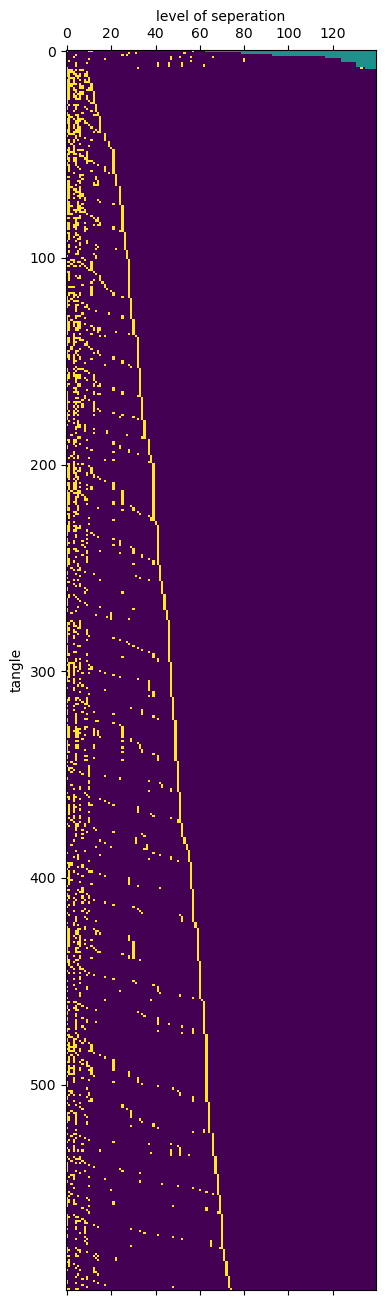

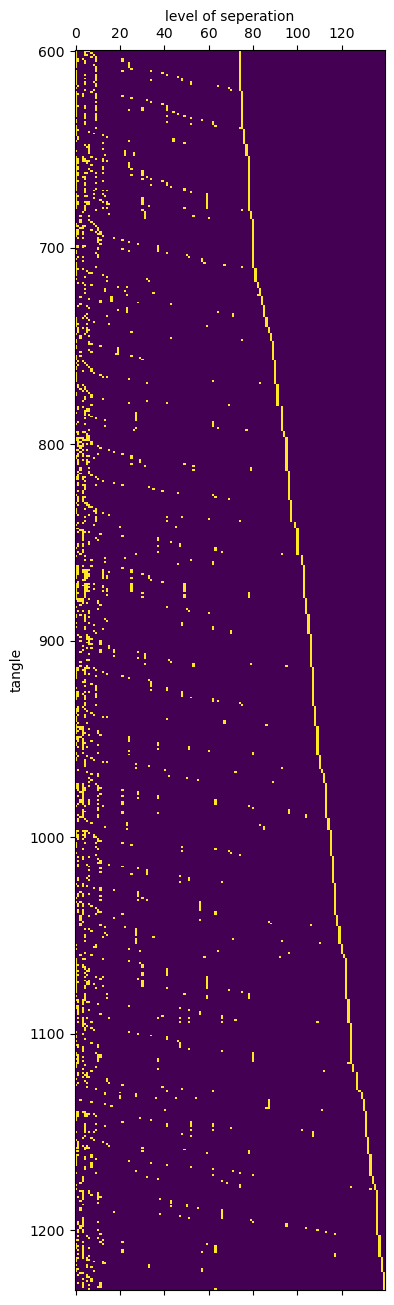

In [7]:
plt.matshow(interesting_umbrella_tm[:600])
plt.gca().set_aspect('auto')
plt.gca().xaxis.set_label_position('top')
plt.xlabel('level of seperation')
plt.ylabel('tangle')
plt.savefig('/home/ocke/Documents/BA-Tangles/tex/images/tm_entropy_K_1.png', bbox_inches='tight')

plt.matshow(interesting_umbrella_tm[600:])
plt.gca().set_aspect('auto')
plt.gca().xaxis.set_label_position('top')
plt.xlabel('level of seperation')
plt.ylabel('tangle')
plt.yticks(ticks = np.arange(0, 601, 100), labels = np.arange(600, 1231, 100))
plt.savefig('/home/ocke/Documents/BA-Tangles/tex/images/tm_entropy_K_2.png', bbox_inches='tight')

Plots for each level the percentage of tangles containing the assoziated keyword:

In [ ]:
plt.scatter(range(interesting_umbrella_tm.shape[1]),((interesting_umbrella_tm == 1).sum(axis = 0) / interesting_umbrella_tm.shape[0]))
plt.xlabel('separation level')
plt.ylabel('proportion of tangles containing separation')
#plt.savefig('/home/ocke/Documents/BA-Tangles/tex/images/proportions_separations.png', bbox_inches='tight')

Counts the number of interessting umbrella tangles containing at least 1 and 2 keywords assosiated with one of the first 10 levels:

In [ ]:
print(((interesting_umbrella_tm[:,:10] == 1).sum(axis = 1) >= 1).sum())
print(((interesting_umbrella_tm[:,:10] == 1).sum(axis = 1) >= 2).sum())

Prints all keywords, that are not contained in any tangle:

In [ ]:
[lvltokeyword[x] for x in np.where((interesting_umbrella_tm == 1).sum(axis = 0) == 0)[0]]

Calculates the core of each tangle and counts the tangles with less than 3 movies in its core:

In [33]:
cores = {}
for i in range(interesting_umbrella_tm.shape[0]):
    pos = np.where(interesting_umbrella_tm[i] == 1)[0]
    core = np.where(oriented_seps[:,pos].min(axis = 1) == 1)[0]
    cores[i] = core.size   
small_cores = [x for x in cores.keys() if cores[x] < 3]
len(small_cores)

618

In [34]:
cores[]

{0: 1,
 1: 4,
 2: 3,
 3: 3,
 4: 2,
 5: 3,
 6: 1,
 7: 2,
 8: 4,
 9: 0,
 10: 0,
 11: 1,
 12: 1,
 13: 1,
 14: 0,
 15: 1,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 1,
 21: 1,
 22: 0,
 23: 0,
 24: 3,
 25: 8,
 26: 0,
 27: 2,
 28: 2,
 29: 4,
 30: 3,
 31: 0,
 32: 1,
 33: 0,
 34: 1,
 35: 1,
 36: 4,
 37: 0,
 38: 1,
 39: 0,
 40: 1,
 41: 2,
 42: 3,
 43: 1,
 44: 5,
 45: 3,
 46: 3,
 47: 3,
 48: 0,
 49: 1,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 1,
 56: 2,
 57: 1,
 58: 2,
 59: 4,
 60: 4,
 61: 1,
 62: 3,
 63: 1,
 64: 0,
 65: 0,
 66: 1,
 67: 2,
 68: 1,
 69: 1,
 70: 1,
 71: 0,
 72: 2,
 73: 2,
 74: 0,
 75: 0,
 76: 1,
 77: 0,
 78: 0,
 79: 0,
 80: 3,
 81: 0,
 82: 2,
 83: 1,
 84: 1,
 85: 0,
 86: 0,
 87: 3,
 88: 3,
 89: 3,
 90: 2,
 91: 3,
 92: 3,
 93: 3,
 94: 1,
 95: 3,
 96: 1,
 97: 4,
 98: 3,
 99: 3,
 100: 3,
 101: 2,
 102: 2,
 103: 5,
 104: 0,
 105: 3,
 106: 3,
 107: 3,
 108: 3,
 109: 1,
 110: 1,
 111: 2,
 112: 4,
 113: 3,
 114: 1,
 115: 3,
 116: 3,
 117: 0,
 118: 1,
 119: 2,
 120: 3,
 121: 1,
 122: 5,
 12

In [32]:
len(cores[i]) for i in [646, 653, 677,906, 1053, 1092, 1146][]

SyntaxError: invalid syntax (745428293.py, line 1)

In [ ]:
for t in small_cores:
    printkeywordsfromtm(interesting_umbrella_tm, t, lvltokeyword)

Tangle:  0
['murder']
['love']
['teenager']
['flashback']
Tangle:  4
['love']
['friendship']
['adultery']
['secret']
Tangle:  6
['violence']
['police']
['detective']
['los angeles']
['shootout']
Tangle:  7
['violence']
['detective']
['los angeles']
['shootout']
['explosion']
Tangle:  9
['murder']
['nudity']
['woman director']
['violence']
['independent film']
['based on novel']
Tangle:  10
['murder']
['nudity']
['woman director']
['sex']
['police']
Tangle:  11
['murder']
['nudity']
['sex']
['violence']
['independent film']
['revenge']
['police']
Tangle:  12
['murder']
['nudity']
['violence']
['female nudity']
['independent film']
['revenge']
['police']
Tangle:  13
['nudity']
['woman director']
['sex']
['female nudity']
['love']
Tangle:  14
['murder']
['nudity']
['sex']
['independent film']
['revenge']
['love']
Tangle:  15
['murder']
['nudity']
['sex']
['revenge']
['police']
['love']
Tangle:  16
['murder']
['nudity']
['woman director']
['sex']
['violence']
['independent film']
['teenage

In [22]:
for i in np.argsort((interesting_umbrella_tm[small_cores] == 1).sum(axis = 1)):
    printkeywordsfromtm(interesting_umbrella_tm, small_cores[i], lvltokeyword)

Tangle:  581
['murder']
['independent film']
['police']
['zombie']
Tangle:  283
['murder']
['sex']
['love']
['los angeles']
Tangle:  978
['sex']
['teenager']
['high school']
['friends']
Tangle:  977
['woman director']
['sex']
['high school']
['friends']
Tangle:  504
['woman director']
['love']
['infidelity']
['party']
Tangle:  651
['murder']
['independent film']
['monster']
['scientist']
Tangle:  349
['woman director']
['independent film']
['love']
['marriage']
Tangle:  905
['sex']
['teenager']
['friendship']
['coming of age']
Tangle:  898
['woman director']
['female nudity']
['independent film']
['coming of age']
Tangle:  485
['murder']
['violence']
['blood']
['party']
Tangle:  696
['love']
['teenager']
['drug']
['secret']
Tangle:  515
['murder']
['violence']
['revenge']
['prison']
['escape']
Tangle:  499
['murder']
['sex']
['drug']
['suicide']
['party']
Tangle:  488
['nudity']
['sex']
['based on novel']
['drug']
['party']
Tangle:  479
['murder']
['sex']
['independent film']
['revenge

In [14]:
interesting_umbrella_tm.shape

(1231, 140)

In [15]:
(interesting_umbrella_tm[small_cores] == 1).sum(axis = 1)

array([4, 4, 5, 5, 7, 7, 5, 6, 6, 7, 4, 4, 4, 7, 7, 7, 5, 4, 5, 5, 5, 4,
       4, 4, 5, 6, 5, 6, 6, 6, 6, 4, 5, 6, 4, 7, 9, 4, 4, 4, 4, 7, 5, 5,
       4, 6, 7, 5, 6, 6, 7, 7, 9, 4, 5, 4, 6, 5, 6, 4, 4, 4, 7, 4, 4, 7,
       7, 4, 5, 4, 5, 5, 6, 4, 4, 5, 4, 6, 5, 4, 4, 4, 5, 7, 7, 7, 7, 6,
       6, 4, 4, 4, 6, 5, 4, 5, 5, 6, 6, 4, 5, 5, 6, 4, 5, 5, 5, 5, 5, 5,
       5, 4, 4, 5, 5, 5, 5, 5, 6, 6, 4, 5, 5, 4, 4, 5, 4, 5, 4, 5, 4, 4,
       5, 6, 6, 5, 7, 4, 6, 6, 4, 4, 5, 6, 5, 7, 5, 5, 5, 4, 4, 5, 5, 5,
       4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 5, 5, 5, 4, 4, 4, 7, 7, 6,
       7, 7, 6, 7, 5, 6, 6, 6, 4, 4, 5, 4, 4, 5, 4, 5, 4, 4, 5, 4, 4, 4,
       4, 5, 5, 6, 4, 6, 4, 4, 4, 6, 4, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4, 5,
       5, 5, 4, 5, 5, 4, 5, 6, 5, 4, 5, 4, 4, 5, 7, 4, 4, 4, 5, 4, 5, 4,
       6, 6, 4, 5, 5, 5, 5, 4, 5, 5, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 5, 6,
       4, 8, 5, 6, 5, 5, 7, 5, 5, 7, 5, 6, 4, 6, 5, 6, 4, 4, 5, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 5, 6, 5, 4, 5,

Counts how many movies are in the corpus of at least one tangle:

In [29]:
((corpora == 1).any(axis = 1)).sum()

2185

Plots the sizes of the corpora:

In [ ]:
plt.scatter(np.argsort(corpora_sizes).astype(str), np.sort(corpora_sizes)[::-1], s = 5)
plt.xticks(np.argsort(corpora_sizes).astype(str)[::75], rotation = 45)
plt.xlabel(r'tangle $\tau$')
plt.ylabel(r'$|C(\tau)|$')
#plt.savefig('/home/ocke/Documents/BA-Tangles/tex/images/body_sizes_F3.png', bbox_inches='tight')

In [ ]:
[cores.get(r, "empty core") for r in representatives]

In [ ]:
data = pd.read_csv('../data/data_K3.csv')
data['keywords'] = data['keywords'].apply(lambda x: ast.literal_eval(x))
data["genres"] = data["genres"].apply(lambda x: ast.literal_eval(x))
len(data) == seps.shape[0]

True

In [14]:
np.sum([gs == [] for gs in data['genres']])

60

In [15]:
print(len(data))
data['genres'].explode().value_counts()

18513


genres
Drama              9093
Comedy             5402
Thriller           4137
Action             3396
Romance            3083
Horror             2641
Crime              2334
Adventure          2011
Science Fiction    1725
Mystery            1298
Fantasy            1278
Family             1257
Documentary        1100
Animation           878
History             705
Music               681
War                 621
Western             465
Foreign             327
TV Movie            276
Name: count, dtype: int64

Prints the corpora of the representatives of the clusters:

In [101]:
for i in range(10):
    print("The corpus of the representative of cluster", i, "contains:")
    print(data['original_title'][corpora[:,representatives[i]] == 1])

In [ ]:
interesting_umbrella_tm[interesting_umbrella_tm[:,0] == 1].max(axis = 0).sum()

In [30]:
lvltokeyword

[['murder'],
 ['nudity'],
 ['woman director'],
 ['sex'],
 ['violence'],
 ['female nudity'],
 ['independent film'],
 ['based on novel'],
 ['revenge'],
 ['police'],
 ['love'],
 ['teenager'],
 ['blood'],
 ['sequel'],
 ['gore'],
 ['male nudity'],
 ['musical'],
 ['friendship'],
 ['sport'],
 ['biography'],
 ['duringcreditsstinger'],
 ['drug'],
 ['monster'],
 ['world war ii'],
 ['suspense'],
 ['rape'],
 ['alien'],
 ['dystopia'],
 ['high school'],
 ['prison'],
 ['serial killer'],
 ['gay'],
 ['suicide'],
 ['death'],
 ['kidnapping'],
 ['martial arts'],
 ['superhero'],
 ['jealousy'],
 ['paris'],
 ['prostitute'],
 ['magic'],
 ['detective'],
 ['father son relationship'],
 ['family'],
 ['hospital'],
 ['aftercreditsstinger'],
 ['los angeles'],
 ['adultery'],
 ['robbery'],
 ['torture'],
 ['marriage'],
 ['infidelity'],
 ['shootout'],
 ['lgbt'],
 ['based on comic'],
 ['wife husband relationship'],
 ['teacher'],
 ['flashback'],
 ['london england'],
 ['slasher'],
 ['new york'],
 ['dying and death'],
 ['ex

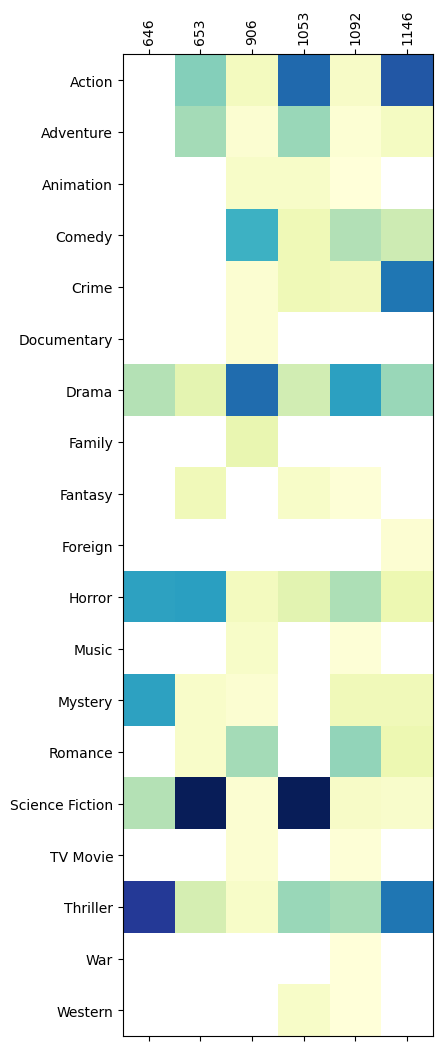

In [ ]:
plot_genre_mat(data, corpora, [646, 653,906, 1053, 1092, 1146])

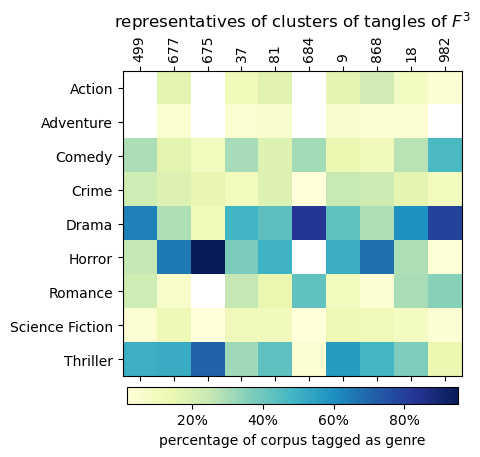

In [10]:
fig = plot_genre_mat(data, corpora, representatives)
plt.title("representatives of clusters of tangles of $F^3$")
cbar = plt.colorbar(fig, orientation = "horizontal", pad = 0.03, shrink = 0.8)
cbar.set_label("percentage of corpus tagged as genre")
cbar.set_ticks(ticks=[0.2,0.4,0.6,0.8],labels= ["20%", "40%", "60%", "80%"])
plt.savefig('/home/ocke/Documents/BA-Tangles/tex/images/genre_mat_cluster_3_vortrag.png', bbox_inches='tight')
#plt.savefig('/home/ocke/Documents/BA-Tangles/tex/images/genre_mat_cluster_3.png', bbox_inches='tight')

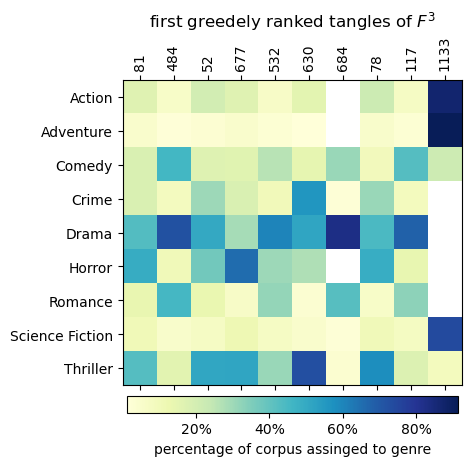

In [11]:
fig = plot_genre_mat(data, corpora, genres[:10])
plt.title("first greedely ranked tangles of $F^3$")
cbar = plt.colorbar(fig, orientation = "horizontal", pad = 0.03, shrink = 0.8)
cbar.set_label("percentage of corpus assinged to genre")
cbar.set_ticks(ticks=[0.2,0.4,0.6,0.8],labels= ["20%", "40%", "60%", "80%"])
plt.savefig('/home/ocke/Documents/BA-Tangles/tex/images/genre_mat_greedy_3.png', bbox_inches='tight')

In [20]:
pd.DataFrame({t: corpus_to_genrecounter(data, corpora, t) for t in genres[:10]})

,81,484,52,677,532,630,684,78,117,1133
genres,,,,,,,,,,
Action,0.166667,0.057895,0.203571,0.165312,0.062500,0.154762,NaN,0.221374,0.070652,0.869565
Adventure,0.049550,0.015789,0.032143,0.048780,0.026786,0.011905,NaN,0.053435,0.027174,0.913043
Animation,0.006757,NaN,0.007143,0.008130,0.008929,NaN,NaN,0.007634,NaN,0.043478
Comedy,0.182432,0.457895,0.167857,0.162602,0.258929,0.142857,0.307692,0.095420,0.423913,0.217391
Crime,0.182432,0.084211,0.303571,0.181572,0.098214,0.559524,0.019231,0.309160,0.086957,NaN
Documentary,NaN,0.005263,NaN,NaN,NaN,NaN,0.038462,NaN,0.010870,NaN
Drama,0.430180,0.721053,0.503571,0.289973,0.602679,0.511905,0.826923,0.442748,0.679348,NaN
Family,NaN,0.005263,0.003571,NaN,NaN,NaN,NaN,NaN,0.021739,0.086957
Fantasy,0.027027,0.042105,0.025000,0.018970,0.013393,0.011905,0.019231,0.019084,0.032609,0.347826
